## Solution 1: Tuning $k$-NN

### a)

Role of hyperparameters

- $k$: determines the size of the neighborhood and thus influences the locality of the model. Smaller neighborhoods reflect the belief that only very similar (close) neighbors should be allowed to weigh into the prediction of a new observation, and predictions may change strongly for only small changes of the input variables. If $k$ is chosen too small, we may encounter overfitting. Conversely, larger neighborhoods produce a more global model with larger parts of the input space receiving the same prediction. Setting $k$ too large may result in underfitting.

- `kernel`: corresponds to the choice of similarity metric. It determines the importance weights in the $k$-neighborhood. 

  Some of the more widely applied kernels include:

  - Rectangular/uniform: all observations within the support of the kernel receive the same degree of similarity, corresponding to unweighted $k$-NN.

  - Triangle: weight is a linear function of distance within the kernel support.

  - Epanechnikov: weight is a quadratic function of distance within the kernel support.

  - Gaussian: weight is a quadratic function of distance. The Gaussian kernel has infinite support, meaning that each pair of observations, no matter how far apart, receives a positive degree of similarity.

  Kernels have a number of canonical properties and  play an important role in statistics (most distance-based operations, such as smoothing, can be expressed using kernels).

- `scale` (logical): defines whether variables should be normalized to equal standard deviation. This is often reasonable to avoid implicit importance weighting through different natural scales (for example, recall that neighborhoods in a bivariate feature space are circular for quadratic distance -- scaling either dimension will change which observations end up in the neighborhood).

### b)

Each learner has a slot `param_set` containing all hyperparameters that can be set during tuning. The key function to define the search space is `ps` (short for parameter space). Furthermore, we need to instantiate every (hyper)parameter with an appropriate type - e.g., characterizing $k$ as integer ensures that only valid neighborhood sizes are queried. `scale` is logical (i.e., binary) and `kernel` is encoded as a factor with levels defining the choices to tune over:

In [1]:
#| label: 1-b
library(mlr3tuning)

search_space <- ps(
  k = p_int(1, 100),
  scale = p_lgl(),
  kernel = p_fct(c("rectangular", "epanechnikov", "gaussian", "optimal"))
)

Loading required package: mlr3

Loading required package: paradox



### c)

We implement the HPO as follows:

In [2]:
#| label: 1-c-1
library(mlr3)
library(mlr3learners)
library(mlr3tuning)

# define task and learner
task <- tsk("german_credit")
set.seed(123)
train_rows <- sample(seq_len(task$nrow), 800, replace = FALSE)
test_rows <- setdiff(seq_len(task$nrow), train_rows)
task_train <- task$clone()$filter(train_rows)
task_test <- task$clone()$filter(test_rows) 
lrn_knn <- lrn("classif.kknn")

# define resampling strategy
resampling <- rsmp("cv", folds = 5)

# create combined terminator object (either criterion, whichever is met first, 
# can invoke the termination)
terminator_evals <- trm("evals", n_evals = 200)
terminator_runtime <- trm("run_time", secs = 30)
terminator <- trm(
  "combo", 
  list(terminator_evals, terminator_runtime), any = TRUE
)

# create tuning instance from the above components
instance <- TuningInstanceSingleCrit$new(
  task = task_train,
  learner = lrn_knn,
  resampling = resampling,
  terminator = terminator,
  search_space = search_space
)

# create random-search optimizer (with parallel computing of batches, useful 
# if we have multiple resources available)
optimizer <- tnr("random_search", batch_size = 20)

Then, press play:

In [3]:
#| label: 1-c-2
#| output: false
set.seed(123)
optimizer$optimize(instance)

INFO  [16:54:32.932] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerRandomSearch>' and '<TerminatorCombo> [any=TRUE]'
INFO  [16:54:32.969] [bbotk] Evaluating 20 configuration(s)
INFO  [16:54:33.074] [mlr3] Running benchmark with 100 resampling iterations
INFO  [16:54:33.109] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 1/5)
INFO  [16:54:33.815] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 2/5)
INFO  [16:54:33.851] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 3/5)
INFO  [16:54:33.896] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 4/5)
INFO  [16:54:33.929] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 5/5)
INFO  [16:54:33.963] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 1/5)
INFO  [16:54:33.999] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 2/5)
INFO  [16:54:34.040] [mlr3] Applying learner 'classif.kknn' on task

k,scale,kernel,learner_param_vals,x_domain,classif.ce
<int>,<lgl>,<chr>,<list>,<list>,<dbl>
15,TRUE,epanechnikov,"15 , TRUE , epanechnikov","15 , TRUE , epanechnikov",0.255


### d)

Plug in custom performance metric (AUC needs the learner to output probabilities):

In [4]:
#| label: 1-d
#| output: false
lrn_knn <- lrn("classif.kknn", predict_type = "prob")
instance_auc <- TuningInstanceSingleCrit$new(
  task = task_train,
  learner = lrn_knn,
  resampling = resampling,
  terminator = terminator,
  search_space = search_space,
  measure = msr("classif.auc")
)
set.seed(123)
optimizer$optimize(instance_auc)

INFO  [16:55:03.268] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerRandomSearch>' and '<TerminatorCombo> [any=TRUE]'
INFO  [16:55:03.279] [bbotk] Evaluating 20 configuration(s)
INFO  [16:55:03.375] [mlr3] Running benchmark with 100 resampling iterations
INFO  [16:55:03.379] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 1/5)
INFO  [16:55:03.412] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 2/5)
INFO  [16:55:03.445] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 3/5)
INFO  [16:55:03.484] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 4/5)
INFO  [16:55:03.516] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 5/5)
INFO  [16:55:03.548] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 1/5)
INFO  [16:55:03.589] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 2/5)
INFO  [16:55:03.625] [mlr3] Applying learner 'classif.kknn' on task

k,scale,kernel,learner_param_vals,x_domain,classif.auc
<int>,<lgl>,<chr>,<list>,<list>,<dbl>
66,TRUE,gaussian,"66 , TRUE , gaussian","66 , TRUE , gaussian",0.764519


### e)

We can make convenient use of the autoplot functions in `mlr3`:

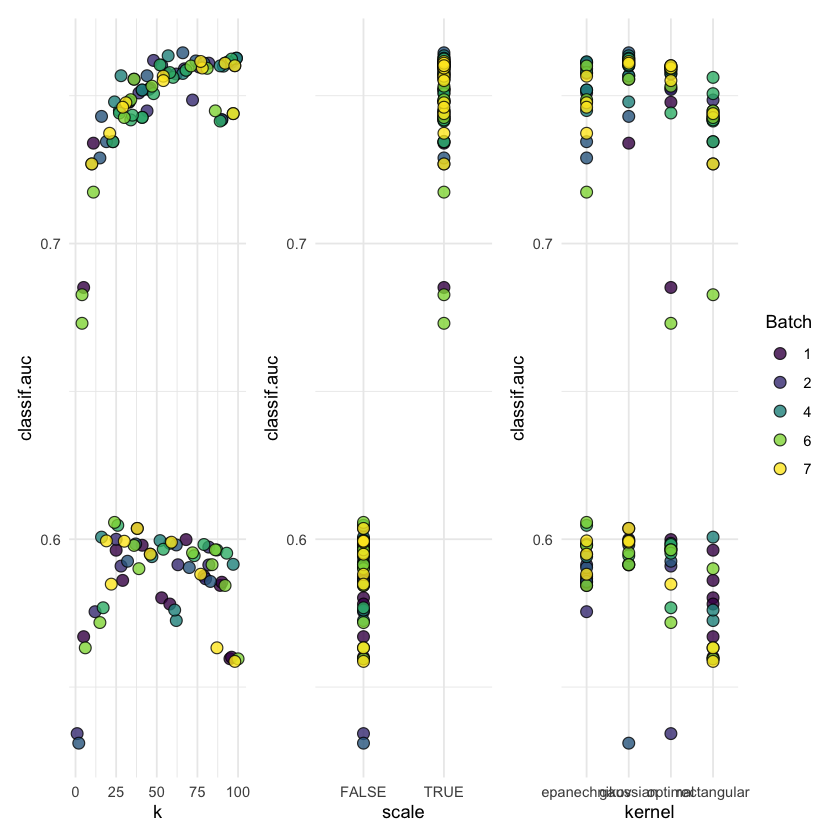

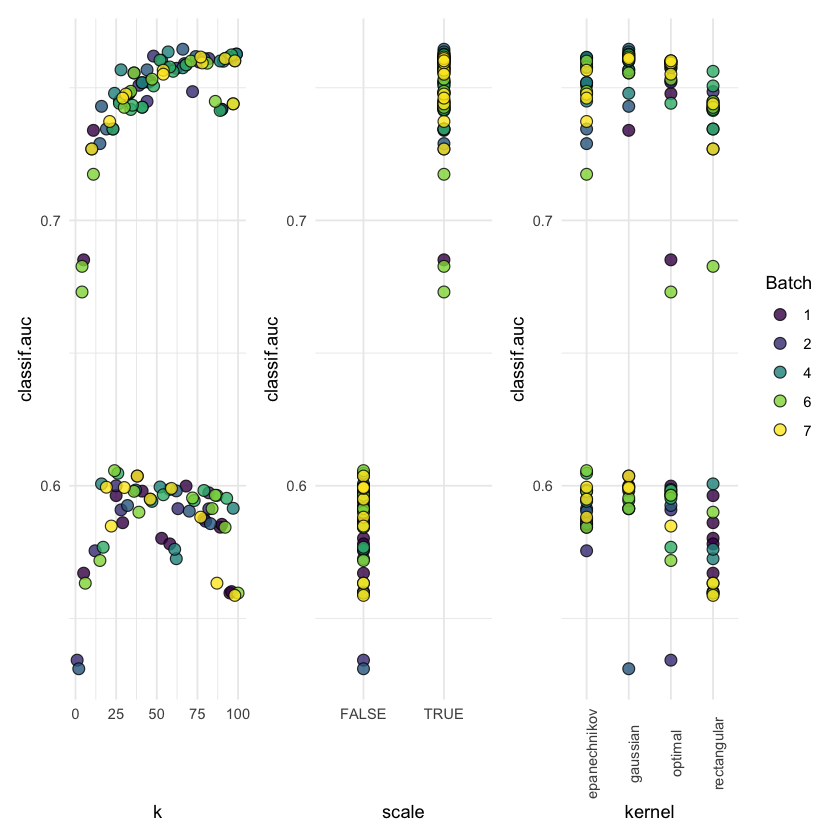

In [5]:
#| label: 1-e
library(mlr3viz)
library(ggplot2)
print(autoplot(instance_auc)) +
  theme(axis.text.x = element_text(angle = 90))

Increasing $k$ initially leads to an improvement that plateaus after around 50 neighbors. Scaling the variables also boosts performance. The choice of the kernel, on the other hand, does not seem to have much impact.

Obviously, the interpretability of these plots is limited: we only see *marginal* effects of individual hyperparameters. The fact that they really interact with each other contributes substantially to the difficulty of the tuning problem. We can clearly see this in the plot for $k$, where we have two quite distinct patterns corresponding to different values of `scale`.


### f)

Tuning $k$ on log-scale requires a modification of the search space. For this, we need to transform the boundaries of the search interval and undo the transformation afterwards via `exp` (plus a rounding operation to ensure $k$ remains an integer number):

In [6]:
#| label: 1-f
#| output: false
search_space = ps(
  "k" = p_dbl(log(1), log(100)),
  scale = p_lgl(),
  kernel = p_fct(c("rectangular", "epanechnikov", "gaussian", "optimal")),
  .extra_trafo = function(x, param_set) {
    x$k = round(exp(x$k))
    return(x)
  }
)
instance_auc <- TuningInstanceSingleCrit$new(
  task = task_train,
  learner = lrn_knn,
  resampling = resampling,
  terminator = terminator,
  search_space = search_space,
  measure = msr("classif.auc")
)

set.seed(123)
optimizer$optimize(instance_auc)

INFO  [16:55:34.557] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerRandomSearch>' and '<TerminatorCombo> [any=TRUE]'
INFO  [16:55:34.570] [bbotk] Evaluating 20 configuration(s)
INFO  [16:55:34.684] [mlr3] Running benchmark with 100 resampling iterations
INFO  [16:55:34.688] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 1/5)
INFO  [16:55:34.717] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 2/5)
INFO  [16:55:34.746] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 3/5)
INFO  [16:55:34.781] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 4/5)
INFO  [16:55:34.810] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 5/5)
INFO  [16:55:34.839] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 1/5)
INFO  [16:55:34.871] [mlr3] Applying learner 'classif.kknn' on task 'german_credit' (iter 2/5)
INFO  [16:55:34.910] [mlr3] Applying learner 'classif.kknn' on task

k,scale,kernel,learner_param_vals,x_domain,classif.auc
<dbl>,<lgl>,<chr>,<list>,<list>,<dbl>
4.053685,TRUE,gaussian,"58 , TRUE , gaussian","58 , TRUE , gaussian",0.7628674


### g)

Performance on test data:

In [7]:
#| label: 1-g
optimal_config <- instance_auc$result_learner_param_vals
lrn_knn$param_set$values <- optimal_config
lrn_knn$train(task_train)
prediction <- lrn_knn$predict(task_test)
prediction$score(msr("classif.auc"))

classif.auc 
   0.779011